In [1]:
!pip install torchview

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchview import draw_graph


class FeatureExtractor(nn.Module):
    def __init__(self, num_features=32):
        super(FeatureExtractor, self).__init__()

        self._model_conv = resnet18()
        self._model_conv.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self._model_conv.fc.in_features
        self._model_conv.fc = nn.Linear(num_ftrs, num_features)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0) * x.size(1), x.size(2), x.size(3), x.size(4))
        out = self._model_conv(x)
        out = self.relu(out)
        return out

class DistributionPoolingFilter(nn.Module):
    def __init__(self,num_bins=21,sigma=0.05):
        super(DistributionPoolingFilter, self).__init__()
        self.num_bins = num_bins
        self.sigma = sigma
        self.alpha = 1/np.sqrt(2*np.pi*self.sigma**2)
        self.beta = -1/(2*(sigma**2))

        sample_points = torch.linspace(0,1,steps=num_bins,dtype=torch.float32,requires_grad=False)
        self.register_buffer('sample_points',sample_points)

    def forward(self,data):
        batch_size,num_instances,num_features = data.size()
        sample_points = self.sample_points.repeat(batch_size,num_instances,num_features,1)
        data = torch.reshape(data,(batch_size,num_instances,num_features,1))
        diff = sample_points - data.repeat(1,1,1,self.num_bins)
        diff_sq = diff**2

        result = self.alpha*torch.exp(self.beta*diff_sq)
        out_unnormalized = torch.sum(result,dim=1)
        norm_coeff = torch.sum(out_unnormalized,dim=2,keepdim=True)
        out = out_unnormalized/norm_coeff
        return out

class RepresentationTransformation(nn.Module):
    def __init__(self,num_features=32,num_bins=21,num_classes=1):
        super(RepresentationTransformation, self).__init__()
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features*num_bins,384),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(384,192),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(192,num_classes)
        )
    def forward(self,x):
        out = self.fc(x)
        return out

class Model(nn.Module):
    def __init__(self,num_classes=1,num_instances=100,num_features=64,num_bins=21,sigma=0.05):
        super(Model, self).__init__()
        self.num_classes = num_classes
        self.num_instances = num_instances
        self.num_features = num_features
        self.num_bins = num_bins
        self.sigma = sigma

        self.feature_extractor = FeatureExtractor(num_features=num_features)
        self.distribution_pooling_filter = DistributionPoolingFilter(num_bins=num_bins,sigma=sigma)
        self.representation_transformation = RepresentationTransformation(num_features=num_features,num_bins=num_bins,num_classes=num_classes)

    def forward(self,x):
        out = self.feature_extractor(x)
        out = torch.reshape(out,(-1,self.num_instances,self.num_features))
        out = self.distribution_pooling_filter(out)
        out = torch.flatten(out,1)
        out = self.representation_transformation(out)
        return out

In [3]:


# Example usage:
mnist_train =  torchvision.datasets.MNIST(root="mnist/mnist_train", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),]))
mnist_test =  torchvision.datasets.MNIST(root="mnist/mnist_test", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),]))

dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=2, shuffle=True)
dataiter = iter(dataloader)
images, labels = next(dataiter)

def create_bag(x, num_images=100, dataset=mnist_train):
  """Creates a bag of MNIST images.

  Args:
    x: The fraction of digit 0 in the bag.
    num_images: The total number of images in the bag.
    dataset: The dataset to sample from.
  """
  indices_0 = np.where(np.array(dataset.targets) == 0)[0]
  indices_7 = np.where(np.array(dataset.targets) == 7)[0]

  num_0 = int(x * num_images)
  num_7 = num_images - num_0

  selected_indices_0 = np.random.choice(indices_0, size=num_0, replace=False)
  selected_indices_7 = np.random.choice(indices_7, size=num_7, replace=False)

  bag_indices = np.random.permutation(np.concatenate([selected_indices_0, selected_indices_7]))
  bag_images = dataset.data[bag_indices]

  bag_images_reshaped = bag_images.view(num_images, 1, 28,28).float()

  return bag_images_reshaped

class MILDataset(torch.utils.data.Dataset):
    def __init__(self, bags, scholar_labels, transform=None):
        self.bags = bags
        self.scholar_labels = scholar_labels
        self.transform = transform

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        bag = self.bags[idx]
        scholar_label = self.scholar_labels[idx]

        if self.transform:
            bag = self.transform(bag)

        return bag, scholar_label

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]


Extracting mnist/mnist_train/MNIST/raw/train-images-idx3-ubyte.gz to mnist/mnist_train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]


Extracting mnist/mnist_train/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/mnist_train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting mnist/mnist_train/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/mnist_train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Extracting mnist/mnist_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/mnist_train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting mnist/mnist_test/MNIST/raw/train-images-idx3-ubyte.gz to mnist/mnist_test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]


Extracting mnist/mnist_test/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/mnist_test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting mnist/mnist_test/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/mnist_test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.58MB/s]

Extracting mnist/mnist_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/mnist_test/MNIST/raw



In [4]:


train_targets = np.round(np.linspace(0,1,num=2000),2)
valid_targets = np.round(np.linspace(0,1,num=200),2)
bags_train = []
bags_valid = []
for i in range(train_targets.shape[0]):
    bag = create_bag(train_targets[i])  # Generate a bag
    bags_train.append(bag)
for i in range(valid_targets.shape[0]):
    bag = create_bag(valid_targets[i])  # Generate a bag
    bags_valid.append(bag)
train_targets = torch.tensor(train_targets).unsqueeze(1)
valid_targets = torch.tensor(valid_targets).unsqueeze(1)
train_dataset = MILDataset(bags_train, train_targets)
valid_dataset = MILDataset(bags_valid, valid_targets)

batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

device='cuda' if torch.cuda.is_available() else 'cpu'
model=Model().to(device)
#visualize a model
model_graph = draw_graph(model, input_size = (1, 100, 1, 28, 28),expand_nested=True)
model_graph.visual_graph.render('model_graph', format='png')
#training/validation
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.000001,weight_decay=0.01)
criterion = nn.L1Loss()

num_epochs = 20

tloss_list = []
vloss_list = []
for epoch in range(num_epochs):
    training_loss = 0
    validation_loss = 0
    print("training")
    num_predictions = 0
    pbar = tqdm(len(train_loader))
    for bags, targets in train_loader:
        bags = bags.to(device)
        targets = targets.to(device)
        outputs = model(bags)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()*targets.size(0)
        num_predictions += targets.size(0)
        pbar.update(1)
    pbar.close()
    training_loss /= num_predictions

    print("validation")
    num_predictions = 0
    pbar = tqdm(len(valid_loader))
    model.eval()
    with torch.no_grad():
      for bags, targets in valid_loader:
          bags = bags.to(device)
          targets = targets.to(device)
          outputs = model(bags)
          loss = criterion(outputs, targets)
          validation_loss += loss.item()*targets.size(0)
          num_predictions += targets.size(0)
          pbar.update(1)
    pbar.close()
    validation_loss /= num_predictions
    tloss_list.append(training_loss)
    vloss_list.append(validation_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')
save_path = 'mil_mnist_model.pth'
torch.save(model.state_dict(), save_path)

training


2000it [00:57, 34.90it/s]


validation


200it [00:01, 182.49it/s]


Epoch 1/20, Training Loss: 0.4655, Validation Loss: 0.4284
training


2000it [00:55, 36.27it/s]


validation


200it [00:01, 190.77it/s]


Epoch 2/20, Training Loss: 0.3718, Validation Loss: 0.3184
training


2000it [00:55, 35.80it/s]


validation


200it [00:01, 175.78it/s]


Epoch 3/20, Training Loss: 0.2839, Validation Loss: 0.2606
training


2000it [00:56, 35.42it/s]


validation


200it [00:01, 187.03it/s]


Epoch 4/20, Training Loss: 0.2493, Validation Loss: 0.2411
training


2000it [00:57, 34.93it/s]


validation


200it [00:01, 186.56it/s]


Epoch 5/20, Training Loss: 0.2322, Validation Loss: 0.2237
training


2000it [00:57, 34.98it/s]


validation


200it [00:01, 186.31it/s]


Epoch 6/20, Training Loss: 0.2055, Validation Loss: 0.1830
training


2000it [00:57, 34.94it/s]


validation


200it [00:01, 170.43it/s]


Epoch 7/20, Training Loss: 0.1472, Validation Loss: 0.1069
training


2000it [00:57, 34.90it/s]


validation


200it [00:01, 184.98it/s]


Epoch 8/20, Training Loss: 0.0563, Validation Loss: 0.0168
training


2000it [00:57, 34.85it/s]


validation


200it [00:01, 186.09it/s]


Epoch 9/20, Training Loss: 0.0107, Validation Loss: 0.0083
training


2000it [00:57, 34.75it/s]


validation


200it [00:01, 186.62it/s]


Epoch 10/20, Training Loss: 0.0071, Validation Loss: 0.0080
training


2000it [00:57, 34.90it/s]


validation


200it [00:01, 167.92it/s]


Epoch 11/20, Training Loss: 0.0060, Validation Loss: 0.0069
training


2000it [00:57, 34.94it/s]


validation


200it [00:01, 185.72it/s]


Epoch 12/20, Training Loss: 0.0055, Validation Loss: 0.0064
training


2000it [00:57, 34.86it/s]


validation


200it [00:01, 185.86it/s]


Epoch 13/20, Training Loss: 0.0050, Validation Loss: 0.0059
training


2000it [00:57, 34.93it/s]


validation


200it [00:01, 184.12it/s]


Epoch 14/20, Training Loss: 0.0045, Validation Loss: 0.0052
training


2000it [00:57, 34.86it/s]


validation


200it [00:01, 169.84it/s]


Epoch 15/20, Training Loss: 0.0043, Validation Loss: 0.0052
training


2000it [00:57, 35.01it/s]


validation


200it [00:01, 185.57it/s]


Epoch 16/20, Training Loss: 0.0040, Validation Loss: 0.0048
training


2000it [00:57, 34.99it/s]


validation


200it [00:01, 184.41it/s]


Epoch 17/20, Training Loss: 0.0039, Validation Loss: 0.0047
training


2000it [00:57, 34.98it/s]


validation


200it [00:01, 186.40it/s]


Epoch 18/20, Training Loss: 0.0036, Validation Loss: 0.0045
training


2000it [00:57, 35.00it/s]


validation


200it [00:01, 175.95it/s]


Epoch 19/20, Training Loss: 0.0034, Validation Loss: 0.0044
training


2000it [00:57, 34.99it/s]


validation


200it [00:01, 186.58it/s]


Epoch 20/20, Training Loss: 0.0034, Validation Loss: 0.0056


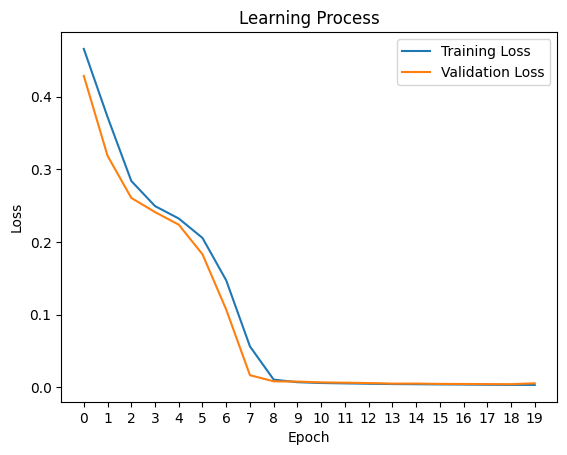

In [5]:
#Visualize the learning process
plt.plot(tloss_list,label='Training Loss')
plt.plot(vloss_list,label='Validation Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,len(tloss_list),1))
plt.ylabel('Loss')
plt.title('Learning Process')
plt.legend()
plt.show()

In [8]:
save_path = 'mil_mnist_model.pth'#change here if using another pretrained model
model = Model()
model.load_state_dict(torch.load(save_path))
model = model.to(device)
model.eval()

<ipython-input-8-465f01eb09a6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Model(
  (feature_extractor): FeatureExtractor(
    (_model_conv): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

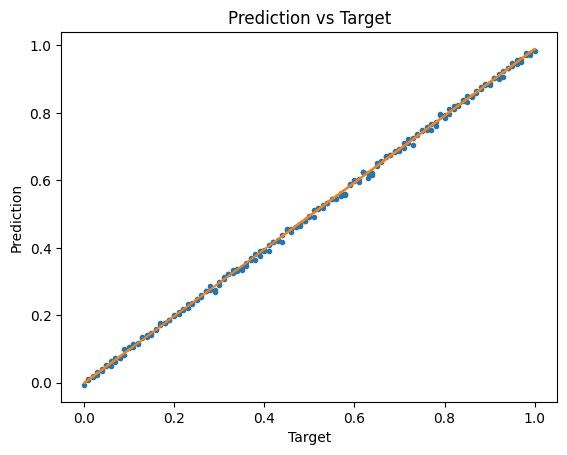

r^2: 0.9989881856795509
Mean Squared Error: 8.433472360942998e-05
Mean Absolute Error: 0.007070153154619036


In [9]:
#predict on test data
test_targets = np.round(np.linspace(0,1,num=200),2)
bags_test = []
for i in range(test_targets.shape[0]):
    bag = create_bag(test_targets[i],dataset=mnist_test)  # Generate a bag
    bags_test.append(bag)
test_targets = torch.tensor(test_targets).unsqueeze(1)
test_dataset = MILDataset(bags_test, test_targets)

batch_size = 1

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

total_loss = 0
all_predictions = []
all_targets = []

with torch.no_grad():  # Disable gradient calculations during evaluation
    for bags, targets in test_loader:
        bags = bags.to(device)
        targets = targets.to(device)
        outputs = model(bags)
        loss = criterion(outputs, targets)  # Calculate loss
        total_loss += loss.item()

        # Store predictions and targets for metric calculation
        all_predictions.extend(outputs.cpu().numpy().flatten())
        all_targets.extend(targets.cpu().numpy().flatten())
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
m,b = np.polyfit(all_targets,all_predictions,1)
r_sq = 1 - (np.sum((all_predictions - all_targets)**2) / np.sum((all_targets - np.mean(all_targets))**2))

plt.plot(all_targets,all_predictions,'.')
plt.plot(all_targets,m*all_targets + b)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('Prediction vs Target')
plt.show()
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(all_targets, all_predictions)
mae = mean_absolute_error(all_targets, all_predictions)
print(f"r^2: {r_sq}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")